In [13]:
# Access the whole dataset and imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

glucose_df = pd.read_csv('glucose.csv')
phases_df = pd.read_csv('hormones_and_selfreport.csv')

In [14]:

glucose_df.loc[glucose_df['glucose_value'] > 15, 'glucose_value'] *= 0.05556  # convert mg/dL to mmol/L
glucose_df[glucose_df['glucose_value'] > 15 ]

glist = (glucose_df
         .groupby(["id", "study_interval", "day_in_study"], as_index=False)
         .agg(glucose_values=("glucose_value", list))
        )

glist["glucose_times"] = (glucose_df
    .groupby(["id", "study_interval", "day_in_study"])["timestamp"]
    .agg(list)
    .values
)

combined = phases_df.merge(
    glist,
    on=["id", "study_interval", "day_in_study"],
    how="left"
)


In [15]:
long_df = combined.explode(['glucose_times', 'glucose_values']).reset_index(drop=True)
long_df["glucose_values"] = pd.to_numeric(long_df["glucose_values"], errors="coerce")

simple_df = long_df[['id', 'day_in_study', 'phase', 'glucose_values', 'glucose_times']].copy()
simple_df.head(10)


,id,day_in_study,phase,glucose_values,glucose_times
0,1,1,Follicular,4.9,00:04:06
1,1,1,Follicular,5.0,00:09:06
2,1,1,Follicular,5.1,00:14:07
3,1,1,Follicular,5.1,00:19:06
4,1,1,Follicular,5.1,00:24:06
5,1,1,Follicular,5.2,00:29:06
6,1,1,Follicular,5.3,00:34:07
7,1,1,Follicular,5.3,00:39:07
8,1,1,Follicular,5.3,00:44:07
9,1,1,Follicular,4.9,00:49:06


Above, I performed the same setup for glucose times to be able to anaylze as a TS.

Below, I generated functions that are 1. useful for data formatting and 2. Calculate a potential cremasters score. This is the core of all further analyses.

In [ ]:
import numpy as np
import pandas as pd

# -----------------------
# Helpers / Preprocessing
# -----------------------
def _to_minutes(t):
    """Convert HH:MM:SS string to minutes since midnight."""
    if pd.isna(t): return np.nan
    h, m, s = map(int, str(t).split(":"))
    return h*60 + m + s/60.0

def prepare_glucose(df):
    """
    Ensure required columns and sorted sampling.
    Adds: minutes (float, minutes since midnight).
    """
    req = {"id", "day_in_study", "phase", "glucose_values", "glucose_times"}
    missing = req - set(df.columns)
    if missing:
        raise ValueError(f"Missing required columns: {missing}")
    out = df.copy()
    out["minutes"] = out["glucose_times"].map(_to_minutes)
    out = out.dropna(subset=["minutes", "glucose_values"])
    out = out.sort_values(["id", "day_in_study", "minutes"])
    return out

# -----------------------
# 1) Overnight basal glucose
# -----------------------
def overnight_basal(df, start="03:00:00", end="05:00:00"):
    start_min = _to_minutes(start)
    end_min   = _to_minutes(end)
    subset = df[(df["minutes"] >= start_min) & (df["minutes"] < end_min)]
    grp = (subset
           .groupby(["id", "day_in_study", "phase"], as_index=False)
           .agg(overnight_mean=("glucose_values", "mean"),
                overnight_median=("glucose_values", "median"),
                n_points=("glucose_values", "size")))
    return grp

# -----------------------
# 2) Variability: SD, CV, MAGE
# -----------------------
def _local_extrema(values):
    """
    Simple local maxima/minima indices (exclude endpoints).
    """
    v = np.asarray(values, dtype=float)
    idx = np.arange(1, len(v)-1)
    peaks  = idx[(v[1:-1] > v[:-2]) & (v[1:-1] > v[2:])]
    trough = idx[(v[1:-1] < v[:-2]) & (v[1:-1] < v[2:])]
    return peaks, trough

def _mage(values, threshold=None):
    """
    Mean Amplitude of Glycemic Excursions:
    - Identify alternating peaks & troughs.
    - Keep excursions with amplitude >= threshold.
    - Default threshold = SD of the series (classic definition).
    """
    v = np.asarray(values, dtype=float)
    if len(v) < 5 or np.allclose(v.std(ddof=1), 0):
        return np.nan
    if threshold is None:
        threshold = np.nanstd(v, ddof=1)

    peaks, trough = _local_extrema(v)
    all_ext = np.sort(np.concatenate([peaks, trough]))
    if all_ext.size < 2:
        return np.nan

    amps = []
    last = None
    for i in all_ext:
        if last is None:
            last = i
            continue
        amp = abs(v[i] - v[last])
        if amp >= threshold:
            amps.append(amp)
            last = i
    return float(np.mean(amps)) if amps else np.nan

def variability_metrics(df):
    """
    Daily SD, CV, and MAGE per id/day/phase.
    """
    def _cv(x):
        m = np.mean(x)
        return np.std(x, ddof=1)/m if m and not np.isclose(m, 0) else np.nan

    def _mage_wrap(x):
        return _mage(np.asarray(x, dtype=float))

    grp = (df.groupby(["id", "day_in_study", "phase"], as_index=False)
             .agg(mean_glucose=("glucose_values", "mean"),
                  sd_glucose=("glucose_values", lambda x: np.std(x, ddof=1)),
                  cv_glucose=("glucose_values", _cv),
                  mage=("glucose_values", _mage_wrap),
                  n_points=("glucose_values", "size")))
    return grp

# -----------------------
# 3) Postprandial response (ΔAUC 0–x min)
# -----------------------
def _nearest_at_time(min_series, val_series, t_min):
    """Return glucose closest in time to t_min."""
    idx = (min_series - t_min).abs().idxmin()
    return val_series.loc[idx]

def infer_meal_times(df_day, rise_thresh=3, horizon_min=30):
    """
    Heuristic to infer meal starts: find times where glucose rises by >= rise_thresh
    within 'horizon_min' minutes. Returns candidate start times (minutes).
    """
    m = df_day["minutes"].to_numpy()
    g = df_day["glucose_values"].to_numpy()
    starts = []
    j = 0
    for i in range(len(m)):
        # look ahead within horizon
        while j < len(m) and m[j] - m[i] <= horizon_min:
            j += 1
        if j > i + 1:
            if (g[j-1] - g[i]) >= rise_thresh:
                starts.append(m[i])
    # de-duplicate nearby starts (>= 60 min apart)
    starts = sorted(starts)
    dedup = []
    for t in starts:
        if not dedup or (t - dedup[-1] >= 60):
            dedup.append(t)
    return dedup

def postprandial_auc(df, meal_times_df=None, window_min=180, baseline_window=30):
    """
    Average ΔAUC 0–window_min after meals (per id/day/phase).
    If meal_times_df is None, infer meals from rises.
    meal_times_df columns (optional): id, day_in_study, meal_minute
    """
    out = []
    for (pid, day, ph), gdf in df.groupby(["id", "day_in_study", "phase"]):
        gdf = gdf.sort_values("minutes")
        mins = gdf["minutes"]
        vals = gdf["glucose_values"]

        if meal_times_df is not None:
            mt = (meal_times_df[(meal_times_df["id"] == pid) &
                                (meal_times_df["day_in_study"] == day)]
                  ["meal_minute"].tolist())
        else:
            mt = infer_meal_times(gdf)

        aucs = []
        for t0 in mt:
            # baseline = average in [t0 - baseline_window, t0)
            base_seg = gdf[(mins >= (t0 - baseline_window)) & (mins < t0)]
            if base_seg.empty:
                base = _nearest_at_time(mins, vals, t0)
            else:
                base = base_seg["glucose_values"].mean()

            # gather samples up to t0 + window_min
            seg = gdf[(mins >= t0) & (mins <= t0 + window_min)]
            if seg.shape[0] < 2:
                continue
            delta = seg["glucose_values"].to_numpy() - base
            # trapezoidal AUC of positive deltas only
            t_rel = seg["minutes"].to_numpy() - t0
            delta = np.maximum(delta, 0.0)
            auc = np.trapz(delta, t_rel)
            aucs.append(auc)

        out.append({
            "id": pid, "day_in_study": day, "phase": ph,
            "pp_auc_0_120": np.mean(aucs) if aucs else np.nan,
            "n_meals": len(aucs)
        })
    return pd.DataFrame(out)

# -----------------------
# 4) Decay slope k after peaks (glucose clearance)
# -----------------------
def decay_slope_k(df, look_forward_min=120, floor_eps=1.0):
    """
    For each detected peak, fit G(t) ~ G_baseline + A*exp(-k t) over the fall.
    We estimate k by linear reg on ln(G - baseline) vs time (only decreasing part).
    Returns per id/day/phase median k.
    """
    rows = []
    for (pid, day, ph), gdf in df.groupby(["id", "day_in_study", "phase"]):
        gdf = gdf.sort_values("minutes")
        m = gdf["minutes"].to_numpy()
        g = gdf["glucose_values"].to_numpy()

        if len(g) < 6:
            rows.append({"id": pid, "day_in_study": day, "phase": ph, "k_decay": np.nan, "n_events": 0})
            continue

        # find simple peaks
        peaks = np.where((g[1:-1] > g[:-2]) & (g[1:-1] > g[2:]))[0] + 1
        ks = []
        for p in peaks:
            t0 = m[p]
            # window after peak
            mask = (m > t0) & (m <= t0 + look_forward_min)
            if mask.sum() < 3:
                continue
            t_seg = m[mask] - t0

            # estimate "baseline" as min in the following 2 hours
            base = np.min(g[mask])
            y = g[mask] - base
            y = np.where(y < floor_eps, np.nan, y)  # avoid log(<=0)
            if np.isnan(y).sum() > (len(y) - 3):
                continue
            # keep only strictly decreasing region vs prior sample (rough heuristic)
            dec_mask = np.diff(np.r_[g[p], g[mask]]) <= 0
            if dec_mask.sum() < 3:
                continue
            t_fit = t_seg[dec_mask]
            y_fit = y[dec_mask]
            y_fit = y_fit[~np.isnan(y_fit)]
            t_fit = t_fit[:len(y_fit)]

            if len(y_fit) < 3:
                continue
            # linear regression on ln(y) = ln(A) - k t
            x = t_fit
            z = np.log(y_fit)
            k = -np.polyfit(x, z, 1)[0]
            if np.isfinite(k) and k > 0:
                ks.append(k)

        rows.append({
            "id": pid, "day_in_study": day, "phase": ph,
            "k_decay": np.median(ks) if ks else np.nan,
            "n_events": len(ks)
        })
    return pd.DataFrame(rows)


In [37]:
# =======================
# EXAMPLE PIPELINE / USE
# =======================
# df_gluc: your dataframe for one or many participants with columns:
# ['id','day_in_study','phase','glucose_values','glucose_times']

# 0) prepare
# df_gluc = <your dataframe>
df_ready = prepare_glucose(simple_df)

# 1) Overnight basal
overnight_df = overnight_basal(df_ready, start="03:00:00", end="05:00:00")

# 2) Variability
var_df = variability_metrics(df_ready)

# 3) Postprandial AUC (uses inferred meals by default; pass a meal_times_df if you have real meals)
pp_df = postprandial_auc(df_ready, meal_times_df=None, window_min=180, baseline_window=30)

# 4) Decay slope k
k_df = decay_slope_k(df_ready, look_forward_min=120, floor_eps=1.0)

# Merge all daily/phase metrics (left join on the intersection keys)
metrics = (overnight_df
           .merge(var_df, on=["id","day_in_study","phase"], how="outer")
           .merge(pp_df,   on=["id","day_in_study","phase"], how="outer")
           .merge(k_df,    on=["id","day_in_study","phase"], how="outer"))

# Now you can aggregate by phase or within-subject:
by_phase = (metrics
            .groupby(["id","phase"], as_index=False)
            .agg(overnight_mean=("overnight_mean", "mean"),
                 cv_glucose=("cv_glucose","mean"),
                 mage=("mage", "mean"),
                 pp_auc_0_120=("pp_auc_0_120", "mean"),
                 k_decay=("k_decay","mean")))

# Display final metrics
by_phase.head(100)

# In a second iteration, let's increase our n by calculating this for each day, id, and phase, as opposed to averaging over days first.





C:\Users\carlo\AppData\Local\Temp\ipykernel_2044\1248694439.py:172: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(delta, t_rel)
C:\Users\carlo\AppData\Local\Temp\ipykernel_2044\1248694439.py:172: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(delta, t_rel)
C:\Users\carlo\AppData\Local\Temp\ipykernel_2044\1248694439.py:172: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(delta, t_rel)
C:\Users\carlo\AppData\Local\Temp\ipykernel_2044\1248694439.py:172: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(delta, t_rel)
C:\Users\carlo\AppData\Local\Temp\ipykernel_2044\1248694439.

,id,phase,overnight_mean,cv_glucose,mage,pp_auc_0_120,k_decay
0,1,Fertility,4.935746,0.131675,1.252786,235.165046,0.011986
1,1,Follicular,4.748653,0.165664,1.330252,387.869667,0.005794
2,1,Luteal,5.397917,0.122473,1.266631,164.495111,0.011401
3,1,Menstrual,5.300000,0.107722,1.092828,NaN,0.007539
4,2,Fertility,5.866250,0.164634,2.140325,359.556978,0.008926
...,...,...,...,...,...,...,...
95,29,Menstrual,6.520833,0.116878,1.284540,132.489167,0.009561
96,30,Fertility,6.868640,0.134384,1.689180,139.228142,0.006804
97,30,Follicular,6.639113,0.126480,1.512871,244.191667,0.009229
98,30,Luteal,6.940541,0.123925,1.500343,185.750833,0.010836


In [38]:
# Now using by phase, we'll group and compute statistics like averages, stddev, etc.
# We want the average of each metric by phase


average_values = by_phase.groupby('phase')[['overnight_mean', 'cv_glucose', 'mage', 'pp_auc_0_120', 'k_decay']].mean()
print(average_values)
# Now calculate standard deviations
std_values = by_phase.groupby('phase')[['overnight_mean', 'cv_glucose', 'mage', 'pp_auc_0_120', 'k_decay']].std()
print(std_values)

            overnight_mean  cv_glucose      mage  pp_auc_0_120   k_decay
phase                                                                   
Fertility         6.099333    0.146906  1.812430    260.923733  0.010036
Follicular        6.002544    0.153107  1.819583    242.695722  0.010050
Luteal            6.204440    0.146419  1.796953    257.223861  0.010297
Menstrual         6.183748    0.144190  1.774495    237.148778  0.010836
            overnight_mean  cv_glucose      mage  pp_auc_0_120   k_decay
phase                                                                   
Fertility         0.608738    0.027404  0.363435     77.015012  0.002428
Follicular        0.605768    0.024914  0.328618     78.250387  0.002322
Luteal            0.617747    0.030047  0.375900     91.271067  0.001800
Menstrual         0.603579    0.023347  0.375906     80.416566  0.003374


In [39]:
# === Daily per-person metrics and a daily "Cremaster Score" ===
# Assumes you already defined the helper functions from earlier:
# prepare_glucose, overnight_basal, variability_metrics, postprandial_auc, decay_slope_k

import numpy as np
import pandas as pd



# 0) Prepare raw glucose rows
# df_gluc = <your dataframe with columns: ['id','day_in_study','phase','glucose_values','glucose_times']>
df_ready = prepare_glucose(simple_df)  # adds 'minutes', sorts, etc.

# (optional) daily glucose summary (mean/min/max per day)
daily_glucose = (df_ready
    .groupby(['id','day_in_study','phase'], as_index=False)
    .agg(
        daily_mean_glucose = ('glucose_values', 'mean'),
        daily_min_glucose  = ('glucose_values', 'min'),
        daily_max_glucose  = ('glucose_values', 'max'),
        n_points           = ('glucose_values', 'size')
    )
)

# 1) Compute the four signals PER DAY PER PERSON (these already return daily grain)
overnight_df = overnight_basal(df_ready, start="03:00:00", end="05:00:00")            # overnight_mean/median
var_df       = variability_metrics(df_ready)                                          # mean_glucose, sd, CV, MAGE
pp_df        = postprandial_auc(df_ready, meal_times_df=None, window_min=150)         # pp_auc_0_120
k_df         = decay_slope_k(df_ready, look_forward_min=120, floor_eps=1.0)           # k_decay

# 2) Merge into ONE daily table
daily_metrics = (
    daily_glucose
      .merge(overnight_df, on=['id','day_in_study','phase'], how='left')
      .merge(var_df,       on=['id','day_in_study','phase'], how='left')
      .merge(pp_df,        on=['id','day_in_study','phase'], how='left')
      .merge(k_df,         on=['id','day_in_study','phase'], how='left')
)

# 3) Build a DAILY "Cremaster Score"
#    Higher insulin resistance is reflected by: higher overnight_mean, higher CV, higher MAGE, higher postprandial AUC.
#    Faster clearance (k_decay) is *protective* → subtract it.
score_components = {
    'overnight_mean',    # from overnight_basal
    'cv_glucose',        # from variability_metrics
    'mage',              # from variability_metrics
    'pp_auc_0_120',      # from postprandial_auc
    'k_decay'            # from decay_slope_k (protective)
}

# Ensure columns exist; if some are missing due to sparse data, fill NaN (they’ll drop in z-scores)
for c in score_components:
    if c not in daily_metrics.columns:
        daily_metrics[c] = np.nan

# --- Option A (recommended): within-person normalization (z-scores per id) ---
def z_within_id(s):
    mu = s.mean()
    sd = s.std(ddof=1)
    return (s - mu) / sd if pd.notnull(sd) and sd > 0 else s * np.nan

norm = (daily_metrics
        .groupby('id', group_keys=False)
        .apply(lambda g: g.assign(
            z_overnight = z_within_id(g['overnight_mean']),
            z_cv        = z_within_id(g['cv_glucose']),
            z_mage      = z_within_id(g['mage']),
            z_ppauc     = z_within_id(g['pp_auc_0_120']),
            z_k         = z_within_id(g['k_decay'])
        ))
)

# Equal weights (tune if you want)
norm['cremaster_score_daily'] = (
    + norm['z_overnight']
    + norm['z_cv']
    + norm['z_mage']
    + norm['z_ppauc']
    - norm['z_k']            # subtract: higher k = better clearance
)

daily_scores_within = norm[['id','day_in_study','phase',
                            'daily_mean_glucose','daily_min_glucose','daily_max_glucose','n_points',
                            'overnight_mean','cv_glucose','mage','pp_auc_0_120','k_decay',
                            'cremaster_score_daily']].copy()

# --- Option B: population-level normalization (if you prefer global z-scores) ---
pop = daily_metrics.copy()
def z_global(x): 
    sd = x.std(ddof=1)
    return (x - x.mean())/sd if pd.notnull(sd) and sd > 0 else x * np.nan

for src, dst in [('overnight_mean','Z_overnight'),
                 ('cv_glucose',   'Z_cv'),
                 ('mage',         'Z_mage'),
                 ('pp_auc_0_120', 'Z_ppauc'),
                 ('k_decay',      'Z_k')]:
    pop[dst] = z_global(pop[src])

pop['cremaster_score_daily_global'] = (
    + pop['Z_overnight'] + pop['Z_cv'] + pop['Z_mage'] + pop['Z_ppauc'] - pop['Z_k']
)

daily_scores_global = pop[['id','day_in_study','phase',
                           'daily_mean_glucose','daily_min_glucose','daily_max_glucose','n_points',
                           'overnight_mean','cv_glucose','mage','pp_auc_0_120','k_decay',
                           'cremaster_score_daily_global']].copy()

# 4) Use either `daily_scores_within` (within-person) or `daily_scores_global` (population) downstream.
print("Daily rows (within-person scoring):", len(daily_scores_within))
print(daily_scores_within.head(10))


C:\Users\carlo\AppData\Local\Temp\ipykernel_2044\1248694439.py:172: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(delta, t_rel)
C:\Users\carlo\AppData\Local\Temp\ipykernel_2044\1248694439.py:172: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(delta, t_rel)
C:\Users\carlo\AppData\Local\Temp\ipykernel_2044\1248694439.py:172: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(delta, t_rel)
C:\Users\carlo\AppData\Local\Temp\ipykernel_2044\1248694439.py:172: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  auc = np.trapz(delta, t_rel)
C:\Users\carlo\AppData\Local\Temp\ipykernel_2044\1248694439.

Daily rows (within-person scoring): 3108
   id  day_in_study       phase  daily_mean_glucose  daily_min_glucose  \
0   1             1  Follicular            5.498958                3.7   
1   1             2  Follicular            5.372222                3.9   
2   1             3  Follicular            5.579514                3.7   
3   1             4   Fertility            5.206597                4.2   
4   1             5   Fertility            5.381597                4.2   
5   1             6   Fertility            5.310069                4.4   
6   1             7   Fertility            5.343403                4.5   
7   1             8   Fertility            5.185764                4.3   
8   1             9   Fertility            5.629514                4.0   
9   1            10      Luteal            5.037165                2.6   

   daily_max_glucose  n_points  overnight_mean  cv_glucose      mage  \
0                7.4       288        5.337500    0.119133  1.508333   


C:\Users\carlo\AppData\Local\Temp\ipykernel_2044\1979479190.py:64: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.assign(


   id  day_in_study       phase  daily_mean_glucose  daily_min_glucose  \
0   1             1  Follicular            5.498958                3.7   
1   1             2  Follicular            5.372222                3.9   
2   1             3  Follicular            5.579514                3.7   
3   1             4   Fertility            5.206597                4.2   
4   1             5   Fertility            5.381597                4.2   
5   1             6   Fertility            5.310069                4.4   
6   1             7   Fertility            5.343403                4.5   
7   1             8   Fertility            5.185764                4.3   
8   1             9   Fertility            5.629514                4.0   
9   1            10      Luteal            5.037165                2.6   

   daily_max_glucose  n_points  overnight_mean  cv_glucose      mage  \
0                7.4       288        5.337500    0.119133  1.508333   
1                7.2       288        5.7

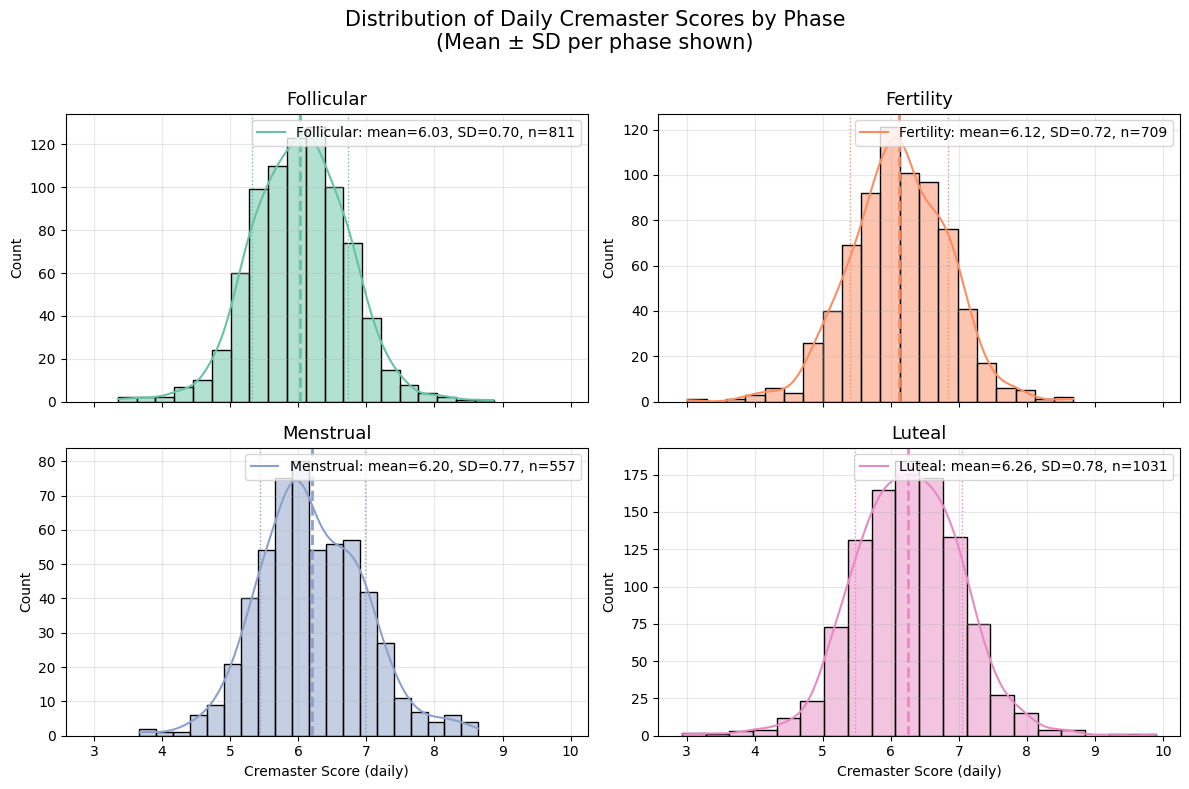


Per-phase summary:


,phase,mean,std,count,mean_std
1,Follicular,6.028387,0.704349,811,6.028 ± 0.704
0,Fertility,6.116272,0.718666,709,6.116 ± 0.719
3,Menstrual,6.202934,0.772422,557,6.203 ± 0.772
2,Luteal,6.258465,0.780858,1031,6.258 ± 0.781


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

# Choose dataset and score column
df_plot = daily_scores_within.copy()    # or daily_scores_global
print(daily_scores_within.head(10))
# print column headers of daily_scores_within
# ['id', 'day_in_study', 'phase', 'daily_mean_glucose', 'daily_min_glucose', 'daily_max_glucose', 'n_points', 
# 'overnight_mean', 'cv_glucose', 'mage', 'pp_auc_0_120', 'k_decay', 'cremaster_score_daily']
score_col = 'pp_auc_0_120'     # or 'cremaster_score_daily_global'
phase_col = 'phase'

# Compute phase-wise stats
phase_stats = (
    df_plot.groupby(phase_col)[score_col]
    .agg(['mean', 'std', 'count'])
    .reset_index()
    .sort_values('mean', ascending=True)
)

# Determine subplot layout
phases = phase_stats[phase_col].tolist()
n_phases = len(phases)
cols = 2
rows = math.ceil(n_phases / cols)

fig, axes = plt.subplots(rows, cols, figsize=(12, 4*rows), sharex=True)
axes = axes.flatten()

palette = sns.color_palette('Set2', n_phases)

for i, (phase, row) in enumerate(phase_stats.set_index(phase_col).iterrows()):
    ax = axes[i]
    subset = df_plot[df_plot[phase_col] == phase][score_col].dropna()
    
    # Plot histogram
    sns.histplot(subset, bins=20, kde=True, color=palette[i], alpha=0.5, ax=ax)
    
    # Add vertical lines for mean ± SD
    ax.axvline(row['mean'], color=palette[i], linestyle='--', linewidth=2)
    ax.axvline(row['mean'] + row['std'], color=palette[i], linestyle=':', linewidth=1)
    ax.axvline(row['mean'] - row['std'], color=palette[i], linestyle=':', linewidth=1)
    
    # Title and legend
    ax.set_title(f"{phase}", fontsize=13)
    ax.set_xlabel("Cremaster Score (daily)")
    ax.set_ylabel("Count")
    ax.grid(alpha=0.3)
    
    # Legend with mean ± SD and count
    ax.legend(
        [f"{phase}: mean={row['mean']:.2f}, SD={row['std']:.2f}, n={int(row['count'])}"],
        loc="upper right",
        frameon=True
    )

# Remove unused axes if any
for j in range(i+1, len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("Distribution of Daily Cremaster Scores by Phase\n(Mean ± SD per phase shown)", fontsize=15)
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

# Optional summary table
print("\nPer-phase summary:")
display(phase_stats.assign(mean_std=lambda d: d['mean'].round(3).astype(str) + " ± " + d['std'].round(3).astype(str)))


In [43]:
import pandas as pd
import numpy as np
from scipy.stats import friedmanchisquare
from statsmodels.stats.anova import AnovaRM
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from itertools import combinations

# pick the metric you want to test (replace with others to loop)
metric = 'cremaster_score_daily'
df = daily_scores_within.copy()

# ensure each subject has at least one value per phase
pivot = df.pivot_table(index='id', columns='phase', values=metric, aggfunc='mean')

# drop subjects with missing phase data (required for repeated-measures)
pivot = pivot.dropna(axis=0)

print(f"\nSubjects included: {pivot.shape[0]}")
print(f"Phases compared: {list(pivot.columns)}")

# -----------------------------
# Option 1: Friedman test (non-parametric)
# -----------------------------
if pivot.shape[1] >= 3:
    stat, p = friedmanchisquare(*[pivot[c] for c in pivot.columns])
    print(f"\nFriedman test for {metric}: χ²={stat:.3f}, p={p:.4e}")
else:
    print("\nNeed ≥3 phases for Friedman test; use paired t-test if only two.")

# -----------------------------
# Option 2: Repeated Measures ANOVA (parametric)
# -----------------------------
long_df = pivot.reset_index().melt(id_vars='id', var_name='phase', value_name=metric)
anova = AnovaRM(long_df, depvar=metric, subject='id', within=['phase']).fit()
print("\nRepeated-Measures ANOVA results:")
print(anova)

# -----------------------------
# Post-hoc pairwise comparisons (Tukey or paired t-tests)
# -----------------------------
from scipy.stats import ttest_rel
phases = list(pivot.columns)
pairs = list(combinations(phases, 2))

print("\nPairwise (paired) t-tests with Bonferroni correction:")
alpha = 0.05 / len(pairs)
for a, b in pairs:
    tstat, pval = ttest_rel(pivot[a], pivot[b], nan_policy='omit')
    signif = "⭐" if pval < alpha else ""
    print(f"{a} vs {b}: t={tstat:.3f}, p={pval:.4e} {signif}")



Subjects included: 39
Phases compared: ['Fertility', 'Follicular', 'Luteal', 'Menstrual']

Friedman test for cremaster_score_daily: χ²=3.123, p=3.7304e-01

Repeated-Measures ANOVA results:
               Anova
      F Value Num DF  Den DF  Pr > F
------------------------------------
phase  0.8364 3.0000 114.0000 0.4766


Pairwise (paired) t-tests with Bonferroni correction:
Fertility vs Follicular: t=1.129, p=2.6609e-01 
Fertility vs Luteal: t=0.351, p=7.2747e-01 
Fertility vs Menstrual: t=1.161, p=2.5305e-01 
Follicular vs Luteal: t=-0.854, p=3.9867e-01 
Follicular vs Menstrual: t=0.379, p=7.0716e-01 
Luteal vs Menstrual: t=1.044, p=3.0325e-01 


POST-EZEKIEL Brain-dump

1. First, there are many statistical tests that solve the problems you're convoluting. 
2. LLM's and AI should be tried either to evaluate, validate, or as a direct analysis of the time-series
3. You have WAY more power, predicting using the direct